# Decision Making I

## Céline Budding && Dorothea Müller 

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

%matplotlib inline

### 1. Extension-Drift Model

### 1.

In [2]:
def euler_maruyama(ffun, gfun, x0, t, **args):
    """Euler Maruyama method for stochastic differential equations. x0 must be a list."""
    dts = np.diff(t).astype(float)
    res = np.zeros((len(t)+1, len(x0)))
    res[0] = x0

    for i in range(1, len(t)):
        # Euler part.
        res[i] = np.multiply(ffun(res[i-1], t, **args), dts[i-1]) + res[i-1]
        
        gfun_res = gfun(res[i-1], t, **args)
        if isinstance(gfun_res, float) or isinstance(gfun_res, int):
            gfun_res = np.repeat(gfun_res, res[i].shape[0])
        
        # For each component, sample from random normal distribution!
        rand_vals = np.random.normal(0, 1, res[i].shape[0])
        
        for j, _ in enumerate(res[i]):
            # For each component, sample noise independently from random normal distribution.
            res[i, j] = res[i, j] + gfun_res[j] * rand_vals[j] * np.sqrt(dts[i-1])
    return res[:len(t)]

In [3]:
x0 = [0]
sigma = 0.5
mu = 0.2
t = np.linspace(0, 10, 1001)
n_sm = 5

In [4]:
ffn = lambda x, t, **args: args['mu']
gfn = lambda x, t, **args: args['sigma']

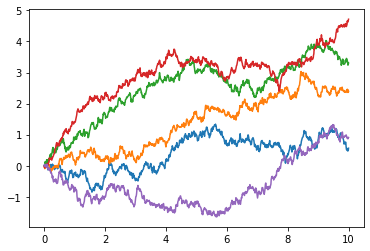

In [5]:
for run in range(n_sm):
    res = euler_maruyama(ffn, gfn, x0, t, sigma = 0.5, mu = 0.2)
    plt.plot(t, res)

### 2.

In [6]:
def simulate_up(a = 1, mu_val= [-0.1, 0, 0.1, 0.2, 0.5], n=200, sigma=0.5):

    perc_up = np.zeros(len(mu_val))
    res = np.zeros(len(t))
    
    for i, mu in enumerate(mu_val):
    
        n_successfull = 0
        for _ in range(n):
            
            res[-1] = 0
#             # Resample when no decision boundary is found
            while(res[-1] < a and res[-1] > -a):
                res = euler_maruyama(ffn, gfn, x0, t, mu=mu, sigma=sigma)
#             res = euler_maruyama(ffn, gfn, x0, t, mu = mu, sigma=sigma)
        
            if res[-2] > a:
                n_successfull +=1

        perc_up[i] = n_successfull/n  * 100
        
    return perc_up

In [7]:
mu_val = [-0.1, 0, 0.1, 0.2, 0.5]
a_val = [0.5, 1, 2]
n = 200

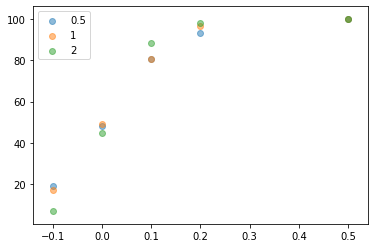

In [8]:
for a in a_val:
    res_a = simulate_up(a = a)
    plt.scatter(mu_val, res_a, label = f"{a}", alpha = 0.5)

plt.legend()

* For a lower mu, it is more likely that we end below the negative decision boundary and vice versa.

* **What happens to this curve if you double, what if you halve the value of a?**
If the value is halfed, the percentage of 'up' trials go down. This can be explained as random fluctuations are more likely to go over the decision boundary, even if it is in the different direction than the drift. Vice versa, if the decision boundary is really high, random flucuations are more likely to push the system over the decision boundary.

We will pick a value of mu = 0.05 to reach 70% up-trials.

### 3.

In [9]:
def simulate_times(a = 1, mu_val= 0.05, n=2000, sigma=0.5):
    res = np.zeros(len(t))
    
    yes_times = []
    no_times = []
    
    for _ in range(n):   
        res[-1] = 0
        idx_greater = n+1
        idx_smaller = n+1

        # Resample when no decision boundary is found
        while(res[-1] < a and res[-1] > -a):
            res = euler_maruyama(ffn, gfn, x0, t, mu=mu, sigma=sigma).flatten()

        # Compare occurences.
        if res[res>a].size != 0:
            idx_greater = np.argwhere(res>a)[0][0]

        if res[res<-a].size != 0:
            idx_smaller = np.argwhere(res<-a)[0][0]

        if idx_greater < idx_smaller:
            yes_times.append(t[idx_greater])

        else:
            no_times.append(t[idx_smaller])
        
    return yes_times, no_times 

In [10]:
yes_time, no_time = simulate_times()

## 4.

Mean for Up: 3.036335750139431


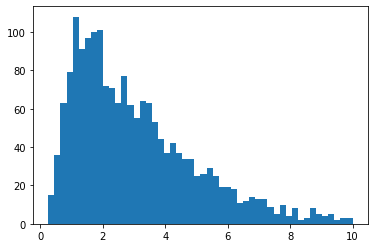

In [11]:
plt.hist(yes_time, bins = 50);
print(f"Mean for Up: {np.mean(yes_time)}")

Mean for Down: 2.9438647342995172


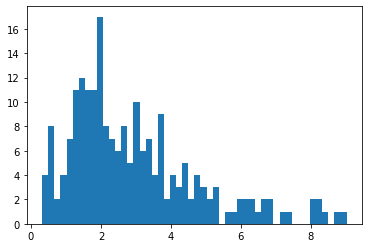

In [12]:
plt.hist(no_time, bins = 50);
print(f"Mean for Down: {np.mean(no_time)}")

**Is this what you would have expected?**

* Size: We would have expected for the height of the up times to be even more higher in comparison to the down times.
* Mean: The mean is similar between the distributions (what we would have expected). However, the mean should be a lot lower judging, judging from slide 38 the reaction times in the histogram should be 2.5 at max, not in the mean.

## 5.

In [13]:
def simulate_up(comb, a = 1, n=100, sigma=0.5):

    perc_up = np.zeros(len(comb))
    res = np.zeros(len(t))
    
    for i, (mean, std) in enumerate(comb):
        n_successfull = 0
        for _ in range(n):
            res[-1] = 0
            # Resample when no decision boundary is found
            while(res[-1] < a and res[-1] > -a):
                res = euler_maruyama(ffn, gfn, x0, t, mu=mu, sigma=sigma, norm_mu=mean, norm_sigma=std)
  
            if res[-1] > a:
                n_successfull +=1

        perc_up[i] = n_successfull/n  * 100
        
    return perc_up

In [14]:
def simulate_times(norm_mu, norm_sigma, a = 1, n=2000, sigma=0.5):
    res = np.zeros(len(t))
    
    yes_times = []
    no_times = []
    
    for _ in range(n):   
        res[-1] = 0
        idx_greater = n+1
        idx_smaller = n+1

        # Resample when no decision boundary is found
        while(res[-1] < a and res[-1] > -a):
            res = euler_maruyama(ffn, gfn, x0, t, sigma=sigma, norm_mu=norm_mu, norm_sigma=norm_sigma).flatten()

        # Compare occurences.
        if res[res>a].size != 0:
            idx_greater = np.argwhere(res>a)[0][0]

        if res[res<-a].size != 0:
            idx_smaller = np.argwhere(res<-a)[0][0]

        if idx_greater < idx_smaller:
            yes_times.append(t[idx_greater])

        else:
            no_times.append(t[idx_smaller])
        
    return yes_times, no_times 

In [15]:
ffn = lambda x, t, **args: np.random.normal(args['norm_mu'], args['norm_sigma'])
gfn = lambda x, t, **args: args['sigma']

First, calculate where it stays around 70\% up.

In [16]:
all_mu = [0.05, 0.1, 0.25, 0.5, 1.0, 1.5]
all_sigma = [0.5, 1.0, 1.5, 2.0, 5.0, 10]

comb = [(mu, sigma) for mu in all_mu for sigma in all_sigma]
perc_up = simulate_up(comb, a = 1, n=100, sigma=0.5)

In [17]:
for i, (mu, sigma) in enumerate(comb):
    print(f"Mu {mu}\t sigma {sigma}: {perc_up[i]}")

Mu 0.05	 sigma 0.5: 70.0
Mu 0.05	 sigma 1.0: 67.0
Mu 0.05	 sigma 1.5: 67.0
Mu 0.05	 sigma 2.0: 64.0
Mu 0.05	 sigma 5.0: 62.0
Mu 0.05	 sigma 10: 49.0
Mu 0.1	 sigma 0.5: 79.0
Mu 0.1	 sigma 1.0: 84.0
Mu 0.1	 sigma 1.5: 79.0
Mu 0.1	 sigma 2.0: 81.0
Mu 0.1	 sigma 5.0: 73.0
Mu 0.1	 sigma 10: 61.0
Mu 0.25	 sigma 0.5: 99.0
Mu 0.25	 sigma 1.0: 98.0
Mu 0.25	 sigma 1.5: 99.0
Mu 0.25	 sigma 2.0: 100.0
Mu 0.25	 sigma 5.0: 96.0
Mu 0.25	 sigma 10: 77.0
Mu 0.5	 sigma 0.5: 100.0
Mu 0.5	 sigma 1.0: 100.0
Mu 0.5	 sigma 1.5: 100.0
Mu 0.5	 sigma 2.0: 100.0
Mu 0.5	 sigma 5.0: 100.0
Mu 0.5	 sigma 10: 95.0
Mu 1.0	 sigma 0.5: 100.0
Mu 1.0	 sigma 1.0: 100.0
Mu 1.0	 sigma 1.5: 100.0
Mu 1.0	 sigma 2.0: 100.0
Mu 1.0	 sigma 5.0: 100.0
Mu 1.0	 sigma 10: 99.0
Mu 1.5	 sigma 0.5: 100.0
Mu 1.5	 sigma 1.0: 100.0
Mu 1.5	 sigma 1.5: 100.0
Mu 1.5	 sigma 2.0: 100.0
Mu 1.5	 sigma 5.0: 100.0
Mu 1.5	 sigma 10: 100.0


Now, we can select the values that result around 70%. However, we will only plot the best result as the simulation takes long (to rerun).

In [20]:
good_comb = [(0.25, 10)]

For mu = 0.25, sigma = 10
Distribution mean Up 0.8940291262135922


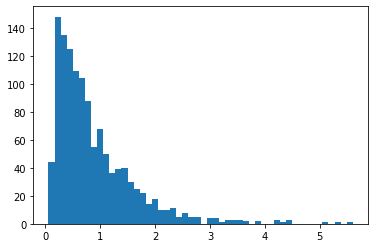

Distribution mean Down 0.8743062827225131


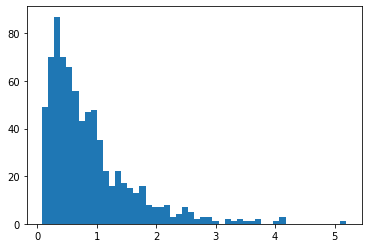

In [21]:
for norm_mu, norm_sigma in good_comb:
    print(f"For mu = {norm_mu}, sigma = {norm_sigma}")
    yes_times, no_times = simulate_times(norm_mu, norm_sigma, n=2000, sigma=0.5)
    plt.hist(yes_times, bins = 50)
    print("Distribution mean Up", np.mean(yes_times))
    plt.show()
    
    plt.hist(no_times, bins=50)
    print("Distribution mean Down", np.mean(no_times))
    plt.show()

In [22]:
The mean goes down. However, the difference

SyntaxError: invalid syntax (<ipython-input-22-9ca79d2e5159>, line 1)